In [3]:
import numpy as np
from matplotlib import pyplot as plt

Janine Birnbaum
May 23, 2019

Model Herschel-Bulkley fluid flow along inclined surface

In [4]:
# Shortcut functions for trigonometric functions in degrees

def sind(theta):
    """Calculate sine of theta in degrees.
    
    :Input:
     - *theta* (array_like) - Angle in degrees.
     
     :Output:
     - (array_like) - Sine value.
    
    """
    
    return np.sin(np.deg2rad(theta))

def cosd(theta):
    """Calculate cosine of theta in degrees.
    
    :Input:
     - *theta* (array_like) - Angle in degrees.
     
     :Output:
     - (array_like) - Cosine value.
    
    """
    
    return np.cos(np.deg2rad(theta))

def tand(theta):
    """Calculate cosine of theta in degrees.
    
    :Input:
     - *theta* (array_like) - Angle in degrees.
     
     :Output:
     - (array_like) - Cosine value.
    
    """
    
    return np.tan(np.deg2rad(theta))

Flow equation:

$ h_t = \left( \frac{\rho g}{K} \right)^{1/n} \frac{\partial}{\partial x} $$ \left[ \frac{n|h_x|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)} \left[(1+2n)h-nY \right]h_x \right] $

$ Y = h - \frac{\tau_y}{\rho g |h_x|} $

Written in dimensionless form: 

$ h_t = \frac{\partial}{\partial x} \left[ \frac{n|h_x|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)}[(1+2n)h-nY]h_x \right] $

$ Y = h - \frac{B}{|h_x|} $

where B = $\frac{\tau_y L}{\rho g H^2}$

$ x = L x', h = Hh', Y = HY', t = \frac L H \left( \frac{KL}{\rho g H^2} \right)^{1/n} t' $

(Balmforth et al., 2007)

Generalized for Herschel-Bulkley fluid on a slope following derivation from Liu & Mei (1989):

$ h_t = \frac{\partial}{\partial x} \left[ \left( \frac{\rho g}{K} \right)^{1/n} \frac{n \left| \sin{\theta} - \frac{\partial}{\partial x} \left( h \cos{\theta} \right) \right|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)} \left[(1+2n)h-nY \right] \left( \sin{\theta} - \frac{\partial}{\partial x} \left( h \cos{\theta} \right) \right) \right] $

$ Y = h - \frac{\tau_y}{\rho g |\sin{\theta} - \frac{\partial}{\partial x} \left( h \cos{\theta} \right)|} $


Dimensional Analysis for spatially and temporally varying slope, density, consistency, and yield stress (constant n): 

$h = H \hat{h}, x = L \hat{x}, \theta = \theta_0 \hat{\theta}, \rho = \rho_0 \hat{\rho}, g = g_0 \hat{g}, K = K_0 \hat{K}, h = H \hat{h}$ 

For height-dominated flow: 

$ t = \frac L H \left( \frac{K_0 L}{\rho_0 g_0 H^2} \right)^{1/n} $

Plug in and drop the hat decoration: 

$ h_t = \frac{\partial}{\partial x} \left[ \left( \frac{\rho g}{K} \right)^{1/n} \frac{n \left| \frac L H \sin{\theta} - \frac{\partial}{\partial x} \left( h \cos{\theta} \right) \right|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)} \left[(1+2n)h-nY \right] \left( \frac L H \sin{\theta} - \frac{\partial}{\partial x} \left( h \cos{\theta} \right) \right) \right] $

$ Y = h - \frac{B \tau_y}{\rho g \left| \frac L H \sin{\theta} - \frac{\partial}{\partial x} \left( h \cos{\theta} \right) \right|} $

$ B = \frac{\tau_{y_0} L}{\rho_0 g_0 H^2} $

In [9]:
def damBreak_RK2(x, L, h0, H, theta, rho, K, tauy, n, g, ts, i):
    """Solve flow for a Herschel-Bulkley fluid with 2-step Runge-Kutta 
    in time, centered in space on an inclined surface.
    
    :Input:
     - *x*     (ndarray(m+2)) - Evaluation points in x [m].
     - *L*     (float)        - Characteristic scale in x [m].
     - *h0*    (ndarray(m+2)) - Initial height at evaluation points in x [m].
     - *H*     (float)        - Characteristic scale in z [m].
     - *theta* (ndarray(m+2)) - Slope in degrees at evaluation points in x [deg].
     - *rho*   (float)        - Fluid density [kg/m^3].
     - *K*     (float)        - Fluid consistency [Pa s].
     - *tauy*  (float)        - Yield stress [Pa].
     - *n*     (float)        - Rheology power law exponent.
     - *g*     (float)        - Gravitational constant [m/s^2].
     - *ts*    (float)        - Final time for simulation [sec].
     - *i*     (int)          - Number of points for discretization in t.
     

    :Output:
     - (ndarray(m+2, i+2)) - Solution of ODE.
     - (ndarray(i+2)) - Evaluation times.
     - (ndarray(m+2, i+2)) - Yield Surface Y.
    """

    # Dimensional numbers
    A = L/H
    B = tauy*L/(rho*g*H**2)
    T = (L/H)*(K*L/(rho*g*H**2))**(1/n)
    tf = ts/T

    # Discretize domain 
    dx = x[1:] - x[:-1]
    dt = tf/(i+1)
    t = np.linspace(0, tf, i+2)

    # Initialize solution
    h = np.zeros((i+2,x.size))
    Y = np.zeros((i+2,x.size))
    
    h[0,:] = h0
    
    # Solve
    for k in np.arange(i+1):
        h_copy = h[k,:]
        
        for j, s in enumerate([0.5, 1]):
            
            hr = (h[k+j,2:] + h[k+j,1:-1])/2
            hl = (h[k+j,1:-1] + h[k+j,:-2])/2
            hxr = A*sind(theta[2:]) - (h[k+j,2:]*cosd(theta[2:]) - h[k+j,1:-1]*cosd(theta[1:-1]))/dx[1:]
            hxl = A*sind(theta[1:-1]) - (h[k+j,1:-1]*cosd(theta[1:-1]) - h[k+j,:-2]*cosd(theta[:-2]))/dx[:-1]
            Yr  = hr - B/np.abs(hxr)
            Yl  = hl - B/np.abs(hxl)
        
            Yr[Yr<0] = 0
            Yl[Yl<0] = 0
        
            Qr = n*(np.abs(hxr)**(1/n-1)*(Yr)**(1+1/n))/((n+1)*(2*n+1))*((1+2*n)*hr - n*Yr)*hxr
            Ql = n*(np.abs(hxl)**(1/n-1)*(Yl)**(1+1/n))/((n+1)*(2*n+1))*((1+2*n)*hl - n*Yl)*hxl
        
            Qr[hxr==0] = 0
            Ql[hxl==0] = 0
    
            Y[k,1:-1] = (Yr + Yl)/2
            h[k+1,1:-1] = h_copy[1:-1] - s*dt/dx[:-1]*(Qr - Ql)
            
            h[k+1,0] = h[k+1,1]
    
    return h*H, t*T, Y

C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in power
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in multiply
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in power
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply


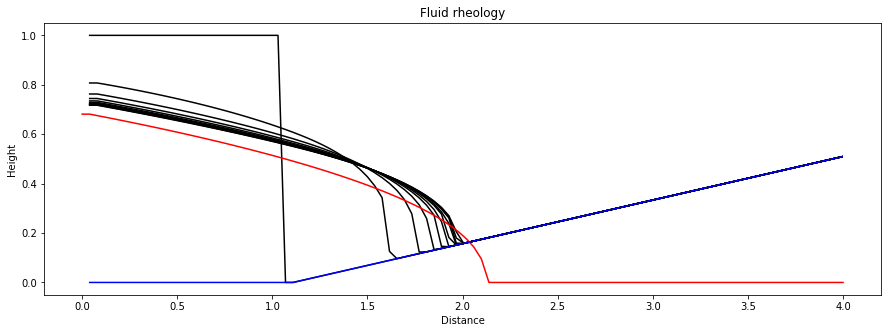

In [10]:
# Example calculation with spatially varying slope

H = 1 # reservoir height in m
L = 1  # reservoir length in m
K = 1  # consistency in Pas
rho = 1 # density in kg/m^3
g = 1   # gravitational acceleration m/s^2
tauy = 0.1 # yield stress in Pa
n = 1.5 # power law exponent

# Discretize domain 
m = 100
x = np.linspace(0, 4, m+2)
dx = x[1] - x[0]

ts = 50 # time in s
i = 50000

# Initial condition
h0 = np.zeros(m+2)
h0[x<=L] = 1

theta = np.zeros_like(x)
theta[x>=1.1] = -10
x_trans = np.cumsum(cosd(theta)*dx)
z0 = np.cumsum(sind(-theta)*dx)
z0 -= np.min(z0)

h, t, Y = damBreak_RK2(x, L, h0, H, theta, rho, K, tauy, n, g, ts, i)
h2, t2, Y2 = damBreak_RK2(x, L, h0, H, np.zeros_like(theta), rho, K, tauy, n, g, ts, i)

fig,ax = plt.subplots(figsize=(15,5))
for k in 5000*np.arange(10):
    ax.plot(x_trans,h[k,:].transpose()*cosd(theta) + z0,'k-',label='Herschel-Bulkley');
ax.plot(x_trans,h[-1,:].transpose()*cosd(theta) + z0,'k-',label='Herschel-Bulkley');
ax.plot(x,h2[-1,:].transpose(),'r-',label='Herschel-Bulkley');
ax.plot(x_trans,z0,'b-',label='Slope');
ax.set_xlabel('Distance')
ax.set_ylabel('Height')
ax.set_title('Fluid rheology');

In [5]:
def damBreak(x, h0, theta, rho, K, tauy, n, g, ts, i):
    
    """Solve flow for a Herschel-Bulkley fluid with 2-step Runge-Kutta 
    in time, centered in space for spatial and temporal variation in 
    density, consistency, yield stress, and power law exponent on an 
    inclined surface.
    
    :Input:
     - *x*     (ndarray(m+2))      - Evaluation points in x [m].
     - *h0*    (ndarray(m+2))      - Initial height at evaluation points in x [m].
     - *theta* (ndarray(m+2))      - Slope in degrees at evaluation points in x [deg].
     - *rho*   (ndarray(m+2, i+2)) - Fluid density [kg/m^3].
     - *K*     (ndarray(m+2, i+2)) - Fluid consistency [Pa s].     
     - *tauy*  (ndarray(m+2, i+2)) - Yield stress [Pa].
     - *n*     (ndarray(m+2, i+2)) - Rheology power law exponent.
     - *g*     (float)             - Gravitational constant [m/s^2].
     - *ts*    (float)             - Final time for simulation [sec].
     - *i*     (int)               - Number of points for discretization in t.
     

    :Output:
     - (ndarray(m+2, i+2)) - Solution of ODE.
     - (ndarray(i+2)) - Evaluation times.
     - (ndarray(m+2, i+2)) - Yield Surface Y.
    """

    # Discretize domain 
    dx = x[1:] - x[:-1]
    dt = ts/(i+1)
    t = np.linspace(0, ts, i+2)

    # Initialize solution
    h = np.zeros((i+2,x.size))
    Y = np.zeros((i+2,x.size))
    
    h[0,:] = h0
    
    # Solve
    for k in np.arange(i+1):
        h_copy = h[k,:]
        
        for j, s in enumerate([0.5, 1]):
            
            hr = (h[k+j,2:] + h[k+j,1:-1])/2
            hl = (h[k+j,1:-1] + h[k+j,:-2])/2
            hxr = sind(theta[2:]) - (h[k+j,2:]*cosd(theta[2:]) - h[k+j,1:-1]*cosd(theta[1:-1]))/dx[1:]
            hxl = sind(theta[1:-1]) - (h[k+j,1:-1]*cosd(theta[1:-1]) - h[k+j,:-2]*cosd(theta[:-2]))/dx[:-1]
            Yr  = hr - tauy[k+j,2:]/(rho[k+j,2:]*g*np.abs(hxr))
            Yl  = hl - tauy[k+j,1:-1]/(rho[k+j,1:-1]*g*np.abs(hxl))
        
            Yr[Yr<0] = 0
            Yl[Yl<0] = 0
            
            nr = n[k+j,2:]
            nl = n[k+j,1:-1]
            
            Ar = (rho[k+j,2:]*g/K[k+j,2:])**(1/nr)
            Al = (rho[k+j,1:-1]*g/K[k+j,1:-1])**(1/nl)
        
            Qr = nr*(np.abs(hxr)**(1/nr-1)*(Yr)**(1+1/nr))/((nr+1)*(2*nr+1))*((1+2*nr)*hr - nr*Yr)*hxr
            Ql = nl*(np.abs(hxl)**(1/nl-1)*(Yl)**(1+1/nl))/((nl+1)*(2*nl+1))*((1+2*nl)*hl - nl*Yl)*hxl
        
            Qr[hxr==0] = 0
            Ql[hxl==0] = 0
    
            Y[k,1:-1] = (Yr + Yl)/2
            h[k+1,1:-1] = h_copy[1:-1] - s*dt/dx[:-1]*(Qr - Ql)
            
            h[k+1,0] = h[k+1,1]
    
    return h, t, Y

C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in less
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide


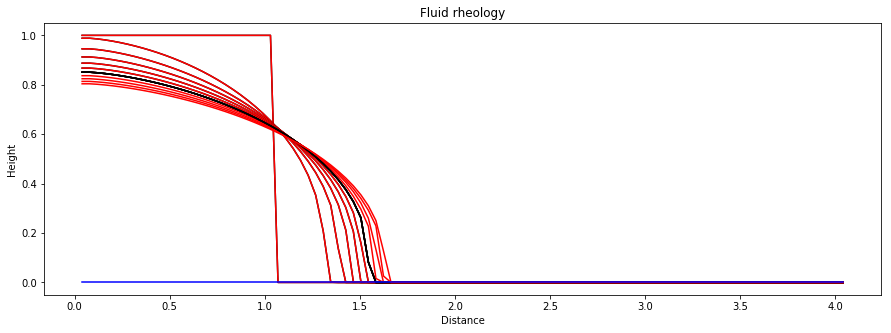

In [15]:
H = 1 # reservoir height in m
L = 1  # reservoir length in m

# Discretize domain 
m = 100
x = np.linspace(0, 4*L, m+2)
dx = x[1] - x[0]

ts = 15 # time in s
i = 50000

theta = 30*np.ones(m+2)

# Dimensional
g = 10   # gravitational acceleration m/s^2

n = 0.5*np.ones((i+2,m+2)) # power law exponent
K = np.ones((i+2,m+2))  # consistency in Pas
rho = np.ones((i+2,m+2)) # density in kg/m^3
tauy = 10*np.ones((i+2,m+2)) # yield stress in Pa
tauy[:30000,:] = 0

# Initial condition
h0 = np.zeros(m+2)
h0[x<=L] = H


theta = np.zeros_like(x)
x_trans = np.cumsum(cosd(theta)*dx)
z0 = np.cumsum(sind(-theta)*dx)
z0 -= np.min(z0)

h, t, Y = damBreak(x, h0, theta, rho, K, tauy, n, g, ts, i)
h2, t2, Y2 = damBreak(x, h0, theta, rho, K, np.zeros((i+2,m+2)), n, g, ts, i)

fig,ax = plt.subplots(figsize=(15,5))
for k in 5000*np.arange(10):
    ax.plot(x_trans,h[k,:].transpose()*cosd(theta) + z0,'k-',label='Herschel-Bulkley');
    ax.plot(x_trans,h2[k,:].transpose()*cosd(theta) + z0,'r-',label='Herschel-Bulkley');
ax.plot(x_trans,h[-1,:].transpose()*cosd(theta) + z0,'k-',label='Herschel-Bulkley');
ax.plot(x_trans,h2[-1,:].transpose()*cosd(theta) + z0,'r-',label='Herschel-Bulkley');
ax.plot(x_trans,z0,'b-',label='Slope');
ax.set_xlabel('Distance')
ax.set_ylabel('Height')
ax.set_title('Fluid rheology');

In [121]:
def damBreak_T(x, h0, T0, T_lft, theta, rho, K, tauy, n, g, k_T, cp, ts, i):
    
    """Solve flow for a Herschel-Bulkley fluid with 2-step Runge-Kutta 
    in time, centered in space for spatial and temporal variation in 
    density, consistency, yield stress, and power law exponent on an 
    inclined surface.
    
    :Input:
     - *x*     (ndarray(m+2))      - Evaluation points in x [m].
     - *h0*    (ndarray(m+2))      - Initial height at evaluation points in x [m].
     - *T0*    (ndarray(m+2))      - Initial temperature at evaluation points in x [deg C].
     - *T_lft* (ndarray(i+2))      - Temperature at left boundary [deg C].
     - *theta* (ndarray(m+2))      - Slope in degrees at evaluation points in x [deg].
     - *rho*   (ndarray(m+2, i+2)) - Fluid density [kg/m^3].
     - *K*     (ndarray(m+2, i+2)) - Fluid consistency [Pa s].     
     - *tauy*  (ndarray(m+2, i+2)) - Yield stress [Pa].
     - *n*     (ndarray(m+2, i+2)) - Rheology power law exponent.
     - *g*     (float)             - Gravitational constant [m/s^2].
     - *k_T*   (float)             - Thermal conductivity [W/(m K)].
     - *cp*    (float)             - Specific heat capacity [J/(kg K)].
     - *ts*    (float)             - Final time for simulation [sec].
     - *i*     (int)               - Number of points for discretization in t.
     

    :Output:
     - (ndarray(m+2, i+2)) - Solution of ODE.
     - (ndarray(i+2)) - Evaluation times.
     - (ndarray(m+2, i+2)) - Yield Surface Y.
    """

    # Discretize domain 
    dx = x[1:] - x[:-1]
    dt = ts/(i+1)
    t = np.linspace(0, ts, i+2)

    # Initialize solution
    h = np.zeros((i+2,x.size))
    Y = np.zeros((i+2,x.size))
    T = np.zeros((i+2,x.size))
    
    h[0,:] = h0
    T[0,:] = T0
    
    # Solve
    for k in np.arange(i+1):
        h_copy = h[k,:]
        T_copy = T[k,:]
        
        for j, s in enumerate([0.5, 1]):
            
            hr = (h[k+j,2:] + h[k+j,1:-1])/2
            hl = (h[k+j,1:-1] + h[k+j,:-2])/2
            hxr = sind(theta[2:]) - (h[k+j,2:]*cosd(theta[2:]) - h[k+j,1:-1]*cosd(theta[1:-1]))/dx[1:]
            hxl = sind(theta[1:-1]) - (h[k+j,1:-1]*cosd(theta[1:-1]) - h[k+j,:-2]*cosd(theta[:-2]))/dx[:-1]
            Yr  = hr - tauy[k+j,2:]/(rho[k+j,2:]*g*np.abs(hxr))
            Yl  = hl - tauy[k+j,1:-1]/(rho[k+j,1:-1]*g*np.abs(hxl))
        
            Yr[Yr<0] = 0
            Yl[Yl<0] = 0
            
            nr = n[k+j,2:]
            nl = n[k+j,1:-1]
            
            Ar = (rho[k+j,2:]*g/K[k+j,2:])**(1/nr)
            Al = (rho[k+j,1:-1]*g/K[k+j,1:-1])**(1/nl)
            
            Tr = (T[k+j,2:] + T[k+j,1:-1])/2
            Tl = (T[k+j,1:-1] + T[k+j,:-2])/2
            
            Txr = (T[k+j,2:] - T[k+j,1:-1])/dx[1:]
            Txl = (T[k+j,1:-1] - T[k+j,:-2])/dx[:-1]
        
            Qr = nr*(np.abs(hxr)**(1/nr-1)*(Yr)**(1+1/nr))/((nr+1)*(2*nr+1))*((1+2*nr)*hr - nr*Yr)*hxr
            Ql = nl*(np.abs(hxl)**(1/nl-1)*(Yl)**(1+1/nl))/((nl+1)*(2*nl+1))*((1+2*nl)*hl - nl*Yl)*hxl
        
            Qr[hxr==0] = 0
            Ql[hxl==0] = 0
    
            Y[k,1:-1] = (Yr + Yl)/2
            h[k+1,1:-1] = h_copy[1:-1] - s*dt/dx[:-1]*(Qr - Ql)
            T[k+1,1:-1] = np.nan_to_num((T_copy[1:-1]*h_copy[1:-1] - s*dt/dx[:-1]*(T[k+j,1:-1]*Qr - T[k+j,:-2]*Ql))/h[k+1,1:-1]) + s*dt/dx[:-1]*(k_T/(rho[k+j,2:]*cp)*Txr - k_T/(rho[k+j,1:-1]*cp)*Txl)
            
            
            h[k+1,0] = h[k+1,1]
            T[k+1,0] = T_lft[k+1]
    
    return h, t, Y, T

C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less
C:\Users\Janine\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide


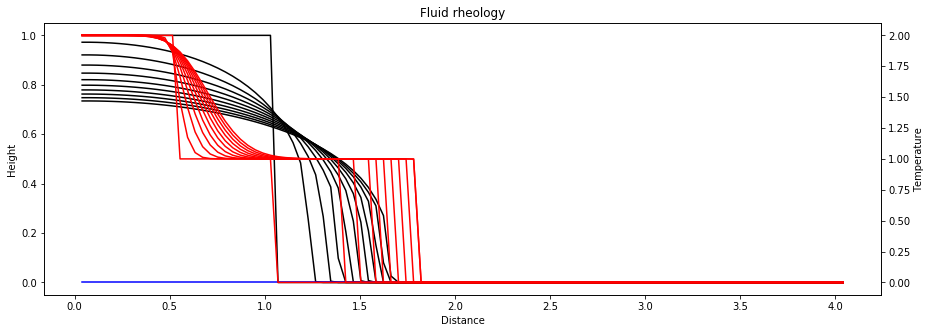

In [123]:
H = 1 # reservoir height in m
L = 1  # reservoir length in m

# Discretize domain 
m = 100
x = np.linspace(0, 4*L, m+2)
dx = x[1] - x[0]

ts = 5 # time in s
i = 10000

theta = 30*np.ones(m+2)

# Dimensional
g = 10   # gravitational acceleration m/s^2
k_T = 0.001  # thermal conductivity
cp = 1   # thermal diffusivity

n = np.ones((i+2,m+2)) # power law exponent
K = np.ones((i+2,m+2))  # consistency in Pas
rho = np.ones((i+2,m+2)) # density in kg/m^3
tauy = 0*np.ones((i+2,m+2)) # yield stress in Pa

# Initial condition
h0 = np.zeros(m+2)
h0[x<=L] = H
T0 = np.zeros(m+2)
T0[x<=L] = 1
T0[x<=L/2] = 2
T_lft = 2*np.ones(i+2)

theta = np.zeros_like(x)
x_trans = np.cumsum(cosd(theta)*dx)
z0 = np.cumsum(sind(-theta)*dx)
z0 -= np.min(z0)

h, t, Y, T = damBreak_T(x, h0, T0, T_lft, theta, rho, K, tauy, n, g, k_T, cp, ts, i)


fig,ax = plt.subplots(figsize=(15,5))
ax2 = ax.twinx()
for k in 1000*np.arange(10):
    ax.plot(x_trans,h[k,:].transpose()*cosd(theta) + z0,'k-',label='Herschel-Bulkley');
    ax2.plot(x_trans,T[k,:].transpose()*cosd(theta) + z0,'r-',label='Herschel-Bulkley');
ax.plot(x_trans,h[-1,:].transpose()*cosd(theta) + z0,'k-',label='Herschel-Bulkley');
ax2.plot(x_trans,T[-1,:].transpose()*cosd(theta) + z0,'r-',label='Herschel-Bulkley');
ax.plot(x_trans,z0,'b-',label='Slope');
ax.set_xlabel('Distance')
ax.set_ylabel('Height')
ax2.set_ylabel('Temperature')
ax.set_title('Fluid rheology');